In [10]:
%pip install -r requirements.txt
%reload_ext autoreload

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5a2egjsx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5a2egjsx
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


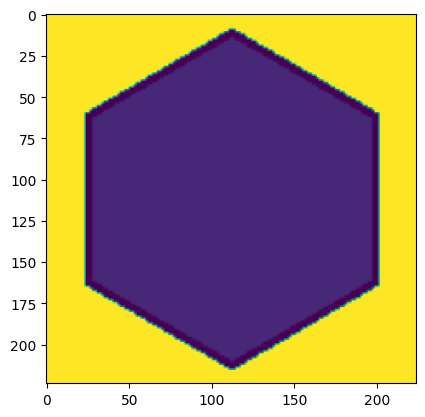

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np
import torch
from raven_dataset import dataset
from torchvision import transforms, utils

path = "/nfs/turbo/coe-chaijy-unreplicated/datasets/RAVEN-10000"
train = dataset(path, "train", 224)
qid = 30000
images, target, meta_target, meta_structure, embedding, indicator = train.__getitem__(qid)
plt.imshow(images[13])
plt.show()

In [13]:
mask_dtype = np.dtype([('bbox', 'intc', (4,)), ('segmentation', object), ('area', float), ('predicted_iou', float)])
data = np.load(f'sam_output/sam_cell_{qid}.npz', allow_pickle=True)
fields = ['bbox', 'segmentation', 'area', 'predicted_iou']

print(data.keys)
# print(len(data['masks']))
cells = []
data_index = 0
for i in range(16):
    current_cell = []
    for j in range(data['cell_sizes'][i]):
        cell = dict()
        for field in fields:
            cell[field] = data[field][data_index]
        current_cell.append(cell)
        data_index += 1
    cells.append(current_cell)
print(data_index)
cells

<bound method Mapping.keys of NpzFile 'sam_output/sam_cell_30000.npz' with keys: cell_sizes, bbox, segmentation, area, predicted_iou>
16


[[{'bbox': array([ 56,  56, 132, 132]),
   'segmentation': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'area': 8461,
   'predicted_iou': 1.002061367034912}],
 [{'bbox': array([292,  68,  88,  88]),
   'segmentation': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'area': 5691,
   'predicted_iou': 1.0018452405929565}],
 [{'bbox': array([481,  33, 1

In [14]:
import create_embedding
# Convert each mask to crop it
image_width = 896
cell_width = image_width // 4
def crop_mask(mask):
    x, y, w, h = mask['bbox']
    x_start = x - (x % cell_width)
    y_start = y - (y % cell_width)
    mask['binary'] = mask['segmentation'][y_start:y_start + cell_width, x_start:x_start + cell_width]
    # and add embeddings
    mask['embedding'] = create_embedding.embed(mask['binary'])
    return mask

cells = [[crop_mask(mask) for mask in cell] for cell in cells]

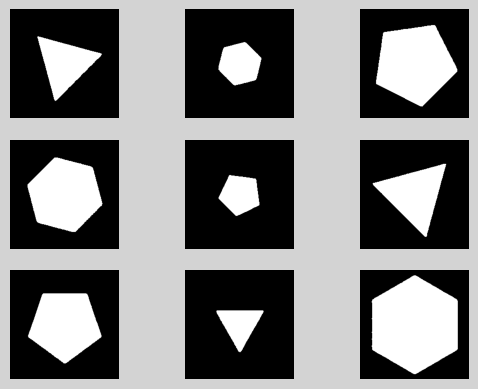

In [29]:
answer = 5
fig, ax = plt.subplots(3, 3)
for a in ax.ravel():
    a.set_aspect('equal')
fig.set_facecolor('lightgray')
for i in range(3):
    for j in range(3):
        cell = cells[i * 3 + j]
        if i == 2 and j == 2:
            cell = cells[8 + answer]
        for mask in cell:
            ax[i, j].imshow(mask['binary'], cmap='gray')
        ax[i, j].axis('off')
plt.show()
# print(f"Correct answer: {answer}")
# # Show the 8 possible answers
# fig, ax = plt.subplots(2, 4)
# for a in ax.ravel():
#     a.set_aspect('equal')
# fig.set_facecolor('lightgray')
# for i in range(2):
#     for j in range(4):
#         ax[i, j].imshow(images[8 + i * 4 + j], cmap='gray')
#         ax[i, j].axis('off')
# plt.show()

In [34]:
grid = []

for i in range(3):
    row = []
    for j in range(3):
        cell = cells[i * 3 + j]
        if i == 2 and j == 2:
            cell = cells[8 + answer]
        row.append(cell[0])
    grid.append(row)

# We have a grid of images now
import torch.nn as nn
def similarity(v1, v2):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(v1.unsqueeze(0),
                v2.unsqueeze(0))
    return cos_sim

for i in range(3):
    for j in range(3):
        print(similarity(grid[0][0]['embedding'], grid[i][j]['embedding']))
    print("")

tensor([1.])
tensor([0.7961])
tensor([0.8143])

tensor([0.7776])
tensor([0.8141])
tensor([0.9157])

tensor([0.8142])
tensor([0.9034])
tensor([0.7607])



(16, 512)
Largest drop with k=15


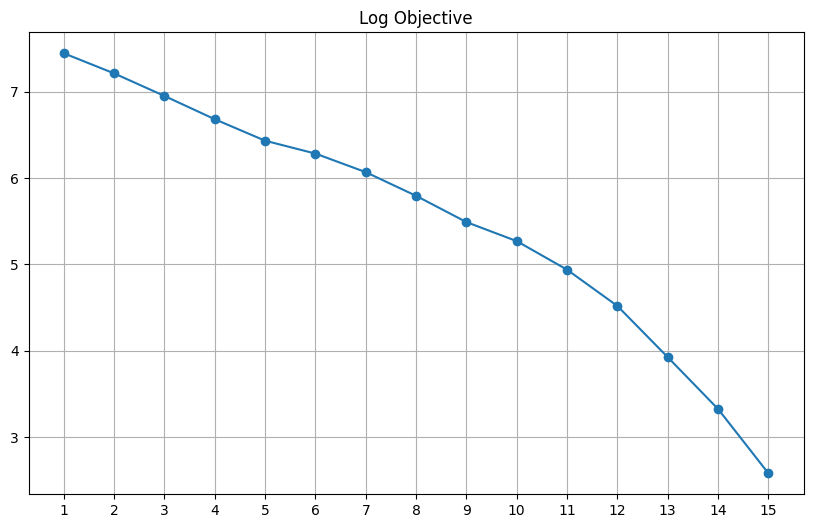

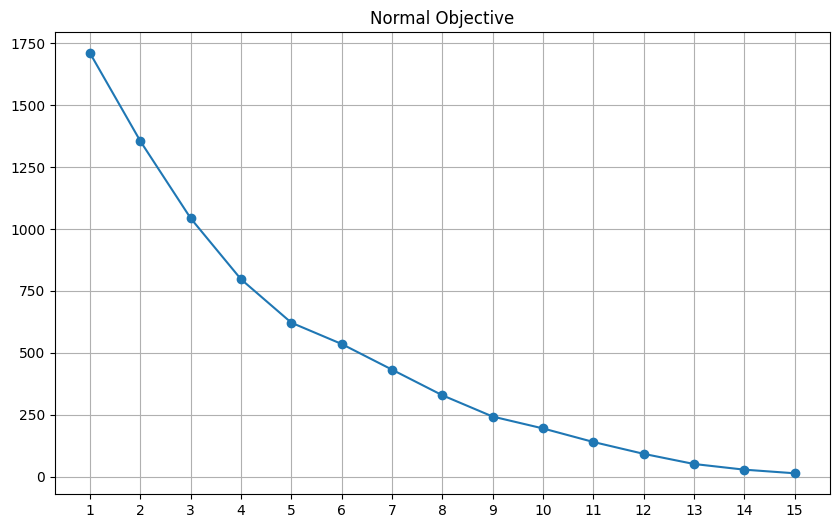

In [38]:

# Create a dataset of features
X = []
for cell in cells:
    for mask in cell:
        X.append(mask['embedding'])
X = np.array(X)
print(X.shape)

from sklearn.cluster import KMeans

objectives = []
log_objectives = []

k_max = min(30, X.shape[0]-1)

largest_drop = 0
largest_drop_k = None

for k in range(1, k_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++', n_init='auto')
    kmeans.fit(X)
    this_objective = kmeans.inertia_
    this_log_objective = np.log(this_objective)
    objectives.append(this_objective)
    if len(log_objectives) > 1:
        drop = log_objectives[-1] - this_log_objective
        if drop > largest_drop:
            largest_drop = drop
            largest_drop_k = k
    log_objectives.append(this_log_objective)

print(f"Largest drop with k={largest_drop_k}")

# Plot the log objective values against the number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), log_objectives, marker='o')
plt.title('Log Objective')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()

# plot normal objective values
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), objectives, marker='o')
plt.title('Normal Objective')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()